<a href="https://colab.research.google.com/github/LucaBarco/Homework2-Caltech101/blob/master/Data_AugmentationHomework2_MLDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Install requirements**

In [1]:
'''!pip3 install 'torch==1.5.0'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm' '''

"!pip3 install 'torch==1.5.0'\n!pip3 install 'torchvision==0.5.0'\n!pip3 install 'Pillow-SIMD'\n!pip3 install 'tqdm' "

**Import libraries**

In [2]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader,ConcatDataset
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

**Set Arguments**

In [3]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.05            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 50      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 40     # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [4]:
# Define transforms for training phase
train_transform1 = transforms.Compose([
                                       transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
train_transform2 = transforms.Compose([ transforms.ColorJitter(brightness=0.1),
                                       transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                       transforms.RandomRotation(degrees=45),
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                     
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
train_transform3 = transforms.Compose([transforms.ColorJitter(contrast=0.1),
                                       transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                       
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])




**Prepare Dataset**

**Prepare Dataloaders**

In [5]:
# Clone github repository with data
! rm -r 'Caltech101'
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/LucaBarco/Homework2-Caltech101
  !mv 'Homework2-Caltech101' 'Caltech101'
DATA_DIR = 'Caltech101/101_ObjectCategories'
from Caltech101.caltech_dataset import Caltech
# Prepare Pytorch train/test Datasets
train_dataset1 = Caltech(DATA_DIR, split='train',  transform=train_transform1)
train_dataset2 = Caltech(DATA_DIR, split='train',  transform=train_transform2)
train_dataset3 = Caltech(DATA_DIR, split='train',  transform=train_transform3)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)
train_dataset=ConcatDataset([train_dataset1, train_dataset2, train_dataset3])
#train_indexes,val_indexes = train_dataset.split_training_set()
train_indexes=range(0,len(train_dataset),2)
val_indexes=range(1,len(train_dataset),2)

val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)


# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Cloning into 'Homework2-Caltech101'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 9398 (delta 18), reused 10 (delta 4), pack-reused 9366
Receiving objects: 100% (9398/9398), 130.30 MiB | 39.35 MiB/s, done.
Resolving deltas: 100% (89/89), done.
Checking out files: 100% (9156/9156), done.
train Ho contato 5784 immagini
train Ho contato 5784 immagini
train Ho contato 5784 immagini
test Ho contato 2893 immagini
Train Dataset: 8676
Valid Dataset: 8676
Test Dataset: 2893


In [6]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**

In [7]:
net = alexnet() # Loading AlexNet model


# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

**Prepare Training**

In [8]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train**

In [9]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

current_step = 0
# Start iterating over the epochs
for epoch in tqdm(range(NUM_EPOCHS)):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  # Step the scheduler
  scheduler.step() 

  0%|          | 0/50 [00:00<?, ?it/s]

Starting epoch 1/50, LR = [0.05]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.624623775482178
Step 10, Loss 4.558492183685303
Step 20, Loss 4.482123374938965
Step 30, Loss 4.424653053283691


  2%|▏         | 1/50 [00:31<25:38, 31.40s/it]

Starting epoch 2/50, LR = [0.05]
Step 40, Loss 4.278072357177734
Step 50, Loss 4.254698276519775
Step 60, Loss 4.1025309562683105


  4%|▍         | 2/50 [01:03<25:13, 31.54s/it]

Starting epoch 3/50, LR = [0.05]
Step 70, Loss 4.142475128173828
Step 80, Loss 4.155610084533691
Step 90, Loss 4.055227279663086


  6%|▌         | 3/50 [01:32<24:13, 30.93s/it]

Starting epoch 4/50, LR = [0.05]
Step 100, Loss 4.255105495452881
Step 110, Loss 4.100701808929443
Step 120, Loss 4.080355167388916
Step 130, Loss 3.825314521789551


  8%|▊         | 4/50 [02:04<23:47, 31.03s/it]

Starting epoch 5/50, LR = [0.05]
Step 140, Loss 3.733532428741455
Step 150, Loss 3.7877891063690186
Step 160, Loss 3.48394513130188


 10%|█         | 5/50 [02:35<23:23, 31.20s/it]

Starting epoch 6/50, LR = [0.05]
Step 170, Loss 4.0823445320129395
Step 180, Loss 4.2045063972473145
Step 190, Loss 4.20796012878418


 12%|█▏        | 6/50 [03:06<22:42, 30.97s/it]

Starting epoch 7/50, LR = [0.05]
Step 200, Loss 4.144148349761963
Step 210, Loss 4.030786991119385
Step 220, Loss 3.918816328048706
Step 230, Loss 3.6793220043182373


 14%|█▍        | 7/50 [03:36<21:59, 30.70s/it]

Starting epoch 8/50, LR = [0.05]
Step 240, Loss 3.917008638381958
Step 250, Loss 3.475938320159912
Step 260, Loss 3.298449754714966


 16%|█▌        | 8/50 [04:06<21:22, 30.54s/it]

Starting epoch 9/50, LR = [0.05]
Step 270, Loss 3.341930866241455
Step 280, Loss 3.2965571880340576
Step 290, Loss 3.2055392265319824


 18%|█▊        | 9/50 [04:36<20:52, 30.55s/it]

Starting epoch 10/50, LR = [0.05]
Step 300, Loss 3.0943377017974854
Step 310, Loss 3.0692672729492188
Step 320, Loss 2.9231979846954346


 20%|██        | 10/50 [05:08<20:33, 30.84s/it]

Starting epoch 11/50, LR = [0.05]
Step 330, Loss 2.533677339553833
Step 340, Loss 2.7472317218780518
Step 350, Loss 2.7098536491394043
Step 360, Loss 2.409316062927246


 22%|██▏       | 11/50 [05:39<20:06, 30.93s/it]

Starting epoch 12/50, LR = [0.05]
Step 370, Loss 2.8168716430664062
Step 380, Loss 2.9601950645446777
Step 390, Loss 2.678283214569092


 24%|██▍       | 12/50 [06:11<19:44, 31.17s/it]

Starting epoch 13/50, LR = [0.05]
Step 400, Loss 2.280935764312744
Step 410, Loss 2.2801101207733154
Step 420, Loss 2.0430948734283447


 26%|██▌       | 13/50 [06:42<19:16, 31.26s/it]

Starting epoch 14/50, LR = [0.05]
Step 430, Loss 1.8434990644454956
Step 440, Loss 1.8308329582214355
Step 450, Loss 1.8351147174835205
Step 460, Loss 1.788029670715332


 28%|██▊       | 14/50 [07:15<18:56, 31.58s/it]

Starting epoch 15/50, LR = [0.05]
Step 470, Loss 1.4535586833953857
Step 480, Loss 1.4505382776260376
Step 490, Loss 1.320257544517517


 30%|███       | 15/50 [07:45<18:13, 31.24s/it]

Starting epoch 16/50, LR = [0.05]
Step 500, Loss 1.1801868677139282
Step 510, Loss 1.5706589221954346
Step 520, Loss 1.2995086908340454


 32%|███▏      | 16/50 [08:16<17:37, 31.12s/it]

Starting epoch 17/50, LR = [0.05]
Step 530, Loss 1.1442967653274536
Step 540, Loss 1.4556769132614136
Step 550, Loss 1.081473469734192
Step 560, Loss 1.027365803718567


 34%|███▍      | 17/50 [08:47<17:10, 31.23s/it]

Starting epoch 18/50, LR = [0.05]
Step 570, Loss 0.9388934969902039
Step 580, Loss 0.9498012661933899
Step 590, Loss 0.9022952914237976


 36%|███▌      | 18/50 [09:19<16:42, 31.31s/it]

Starting epoch 19/50, LR = [0.05]
Step 600, Loss 0.976244330406189
Step 610, Loss 0.809590220451355
Step 620, Loss 0.802201509475708


 38%|███▊      | 19/50 [09:50<16:09, 31.28s/it]

Starting epoch 20/50, LR = [0.05]
Step 630, Loss 0.6934086084365845
Step 640, Loss 0.7581413388252258
Step 650, Loss 0.6575186848640442


 40%|████      | 20/50 [10:22<15:40, 31.36s/it]

Starting epoch 21/50, LR = [0.05]
Step 660, Loss 0.667335569858551
Step 670, Loss 0.6853061318397522
Step 680, Loss 0.5924102067947388
Step 690, Loss 0.6183810830116272


 42%|████▏     | 21/50 [10:52<15:02, 31.12s/it]

Starting epoch 22/50, LR = [0.05]
Step 700, Loss 0.6444834470748901
Step 710, Loss 0.6673372387886047
Step 720, Loss 0.5140278339385986


 44%|████▍     | 22/50 [11:23<14:27, 30.98s/it]

Starting epoch 23/50, LR = [0.05]
Step 730, Loss 0.6466212868690491
Step 740, Loss 0.4916146993637085
Step 750, Loss 0.4713568687438965


 46%|████▌     | 23/50 [11:53<13:48, 30.67s/it]

Starting epoch 24/50, LR = [0.05]
Step 760, Loss 0.4836878478527069
Step 770, Loss 0.520645022392273
Step 780, Loss 0.5710618495941162
Step 790, Loss 0.7621760368347168


 48%|████▊     | 24/50 [12:23<13:15, 30.61s/it]

Starting epoch 25/50, LR = [0.05]
Step 800, Loss 0.5074241757392883
Step 810, Loss 0.5162319540977478
Step 820, Loss 0.4680657684803009


 50%|█████     | 25/50 [12:54<12:42, 30.52s/it]

Starting epoch 26/50, LR = [0.05]
Step 830, Loss 0.6274134516716003
Step 840, Loss 0.5393935441970825
Step 850, Loss 0.4794328808784485


 52%|█████▏    | 26/50 [13:24<12:12, 30.53s/it]

Starting epoch 27/50, LR = [0.05]
Step 860, Loss 0.36332136392593384
Step 870, Loss 0.44099196791648865
Step 880, Loss 0.6900120377540588
Step 890, Loss 0.3840329945087433


 54%|█████▍    | 27/50 [13:55<11:41, 30.52s/it]

Starting epoch 28/50, LR = [0.05]
Step 900, Loss 0.4262097179889679
Step 910, Loss 0.3867228329181671
Step 920, Loss 0.4314837157726288


 56%|█████▌    | 28/50 [14:24<11:05, 30.24s/it]

Starting epoch 29/50, LR = [0.05]
Step 930, Loss 0.18548206984996796
Step 940, Loss 0.43319955468177795
Step 950, Loss 0.41248834133148193


 58%|█████▊    | 29/50 [14:54<10:33, 30.18s/it]

Starting epoch 30/50, LR = [0.05]
Step 960, Loss 0.42474475502967834
Step 970, Loss 0.22770369052886963
Step 980, Loss 0.38374871015548706


 60%|██████    | 30/50 [15:24<10:00, 30.03s/it]

Starting epoch 31/50, LR = [0.05]
Step 990, Loss 0.2305348962545395
Step 1000, Loss 0.4250117242336273
Step 1010, Loss 0.43119922280311584
Step 1020, Loss 0.19788837432861328


 62%|██████▏   | 31/50 [15:54<09:32, 30.16s/it]

Starting epoch 32/50, LR = [0.05]
Step 1030, Loss 0.3161868453025818
Step 1040, Loss 0.2812288701534271
Step 1050, Loss 0.2895418703556061


 64%|██████▍   | 32/50 [16:26<09:10, 30.57s/it]

Starting epoch 33/50, LR = [0.05]
Step 1060, Loss 0.33520591259002686
Step 1070, Loss 0.31157588958740234
Step 1080, Loss 0.31154707074165344


 66%|██████▌   | 33/50 [16:56<08:37, 30.45s/it]

Starting epoch 34/50, LR = [0.05]
Step 1090, Loss 0.3913517892360687
Step 1100, Loss 0.3177654445171356
Step 1110, Loss 0.2156647890806198
Step 1120, Loss 0.39613550901412964


 68%|██████▊   | 34/50 [17:26<08:05, 30.35s/it]

Starting epoch 35/50, LR = [0.05]
Step 1130, Loss 0.34445250034332275
Step 1140, Loss 0.20082074403762817
Step 1150, Loss 0.18019136786460876


 70%|███████   | 35/50 [17:55<07:29, 29.98s/it]

Starting epoch 36/50, LR = [0.05]
Step 1160, Loss 0.35272592306137085
Step 1170, Loss 0.2215060442686081
Step 1180, Loss 0.22135816514492035


 72%|███████▏  | 36/50 [18:25<06:57, 29.82s/it]

Starting epoch 37/50, LR = [0.05]
Step 1190, Loss 0.30348435044288635
Step 1200, Loss 0.1843625009059906
Step 1210, Loss 0.32095229625701904
Step 1220, Loss 0.31972217559814453


 74%|███████▍  | 37/50 [18:55<06:27, 29.83s/it]

Starting epoch 38/50, LR = [0.05]
Step 1230, Loss 0.12924954295158386
Step 1240, Loss 0.2856374979019165
Step 1250, Loss 0.32019704580307007


 76%|███████▌  | 38/50 [19:25<05:58, 29.91s/it]

Starting epoch 39/50, LR = [0.05]
Step 1260, Loss 0.1864929348230362
Step 1270, Loss 0.34549960494041443
Step 1280, Loss 0.30213049054145813


 78%|███████▊  | 39/50 [19:55<05:28, 29.89s/it]

Starting epoch 40/50, LR = [0.05]
Step 1290, Loss 0.24147489666938782
Step 1300, Loss 0.22216860949993134
Step 1310, Loss 0.20304325222969055


 80%|████████  | 40/50 [20:24<04:57, 29.78s/it]

Starting epoch 41/50, LR = [0.0005000000000000001]
Step 1320, Loss 0.3894701898097992
Step 1330, Loss 0.1055765151977539
Step 1340, Loss 0.1621001660823822
Step 1350, Loss 0.09007143974304199


 82%|████████▏ | 41/50 [20:53<04:25, 29.53s/it]

Starting epoch 42/50, LR = [0.005000000000000001]
Step 1360, Loss 0.15226608514785767
Step 1370, Loss 0.08398986607789993
Step 1380, Loss 0.10603466629981995


 84%|████████▍ | 42/50 [21:23<03:56, 29.60s/it]

Starting epoch 43/50, LR = [0.005000000000000001]
Step 1390, Loss 0.11325695365667343
Step 1400, Loss 0.09362488985061646
Step 1410, Loss 0.0761440172791481


 86%|████████▌ | 43/50 [21:52<03:27, 29.61s/it]

Starting epoch 44/50, LR = [0.005000000000000001]
Step 1420, Loss 0.17150160670280457
Step 1430, Loss 0.10539671033620834
Step 1440, Loss 0.07294464856386185
Step 1450, Loss 0.1144854947924614


 88%|████████▊ | 44/50 [22:22<02:58, 29.76s/it]

Starting epoch 45/50, LR = [0.005000000000000001]
Step 1460, Loss 0.059336934238672256
Step 1470, Loss 0.06747530400753021
Step 1480, Loss 0.09776264429092407


 90%|█████████ | 45/50 [22:52<02:28, 29.70s/it]

Starting epoch 46/50, LR = [0.005000000000000001]
Step 1490, Loss 0.040488455444574356
Step 1500, Loss 0.06364542990922928
Step 1510, Loss 0.06073005124926567


 92%|█████████▏| 46/50 [23:22<01:58, 29.64s/it]

Starting epoch 47/50, LR = [0.005000000000000001]
Step 1520, Loss 0.0705847516655922
Step 1530, Loss 0.09289692342281342
Step 1540, Loss 0.09605087339878082
Step 1550, Loss 0.050317633897066116


 94%|█████████▍| 47/50 [23:51<01:29, 29.70s/it]

Starting epoch 48/50, LR = [0.005000000000000001]
Step 1560, Loss 0.07665713131427765
Step 1570, Loss 0.08837860822677612
Step 1580, Loss 0.144720196723938


 96%|█████████▌| 48/50 [24:21<00:59, 29.64s/it]

Starting epoch 49/50, LR = [0.005000000000000001]
Step 1590, Loss 0.05488452687859535
Step 1600, Loss 0.05949276313185692
Step 1610, Loss 0.08263197541236877


 98%|█████████▊| 49/50 [24:50<00:29, 29.58s/it]

Starting epoch 50/50, LR = [0.005000000000000001]
Step 1620, Loss 0.07907380908727646
Step 1630, Loss 0.06677401065826416
Step 1640, Loss 0.050408270210027695


100%|██████████| 50/50 [25:20<00:00, 30.41s/it]


**Validation**

In [10]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
print(str(len(val_dataloader)))
for images, labels in tqdm(val_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(val_dataset))

print('Validation Accuracy: {}'.format(accuracy))

  0%|          | 0/34 [00:00<?, ?it/s]

34


100%|██████████| 34/34 [00:31<00:00,  1.08it/s]

Validation Accuracy: 0.545182111572153


**Test**

In [11]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 12/12 [00:09<00:00,  1.20it/s]

Test Accuracy: 0.5641202903560318


['accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'Faces', 'Faces_easy', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'Leopards', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'Motorbikes', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy', 'soccer_ball', 'stapler

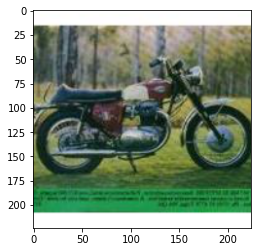

			Motorbikes


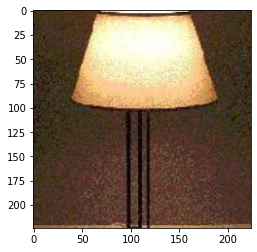

			lamp


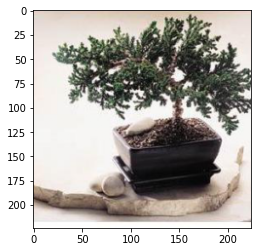

			bonsai


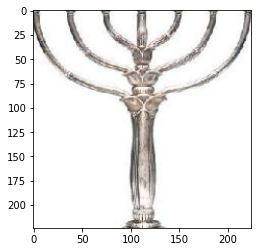

			menorah


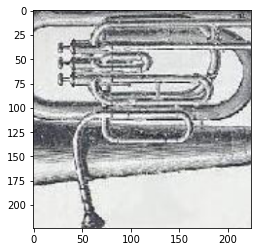

			euphonium


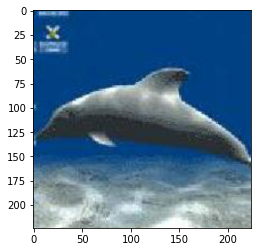

			airplanes


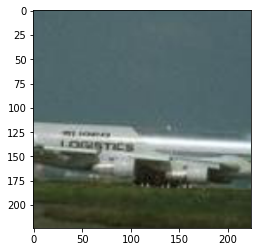

			airplanes


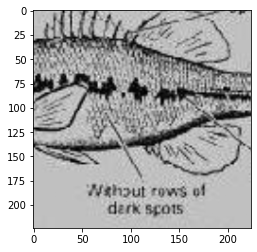

			bass


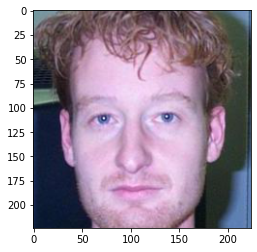

			Faces_easy


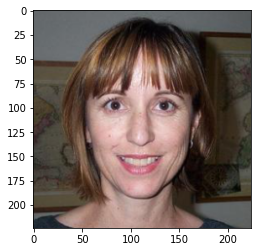

			Faces


In [12]:
import matplotlib.pyplot as plt
import random 
import numpy as np
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

labels=list(test_dataset.return_labels())
print (labels)
#Get some random training images
for i in range(0,10):
  index=len(test_dataset)-1
  image,label=test_dataset[random.randint(0,index)]
  imagex = image.unsqueeze(0)
  imageCuda=imagex.to(DEVICE)
  outputs = net(imageCuda)
  preds = torch.max(outputs.data, 1)
  imshow(image)
  print( "\t\t\t"+labels[preds.indices.cpu().numpy()[0]])